# Introduction to Density Estimation

-----

In this IPython notebook, we explore how to represent data by using a density estimate, of which the most simple example is the histogram. After reviewing the advantages and disadvantages of using a histogram, we introduce the kernel density estimate and demonstrate how this method can be used to model a data set. While a density estimate can be an important visualization tool, they are often used to create probabilistic models of the underlying data distribution, and as such, can be used to generate new samples for further analysis. We perform density estimation on the Iris and hand-written digit data used in previous notebooks. First, we will set up this notebook, and introduce the Iris data before performing density estimation on this data.

-----

In [1]:
# Set up notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

# Load the Iris Data
iris = sns.load_dataset("iris")

-----

## Iris Data

In this notebook, we will use the standard Iris classification data set to explore density estimation. The four primary dimensions of the data include Sepal Length, Sepal Width, Petal Length, and Petal Width.

The data set consists of 150 total measurements of three different types of Iris flowers, equally divided between three classes: Iris Setosa, Iris Versicolor, and Iris Virginica. To get started, we will pick one dimension (or feature) in the data set and explore the distribution of the values in this dimension. For simplicity, we will select the _Sepal Length_ feature. On its own, we simply have 150 measurements of this feature. These measurements can be used to visualize the distribution, or they could be used to build a predictive model by assuming that they are samples drawn from the parent distribution for this feature (which in general would be an unknown function).

As a first step, we can simply plot the one-dimensional distribution. Rather than simply plotting the points themselves, it is customary to plot short lines at each location of the points. This type of plot is known as a **rug plot** due to its similarity to a carpet with the points appearing like carpet fibers. In the following cell, we plot the _Sepal Length_ feature as a rug plot. However, since some measurements have the same value, the initial plot does not represent the full data set. Thus, in the second plot, we add a random _jitter_ to each point to more clearly indicate locations where the density of points is higher.

-----

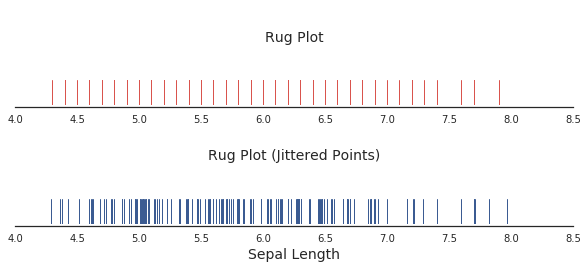

In [2]:
# We make our own rug plots, wrapping seaborn calls.
# One plot needs jittered points.
jitter = 0.05

# Collect our two data sets
data_iris = []
data_iris.append(iris['sepal_length'].as_matrix())
data_iris.append(iris['sepal_length'].as_matrix() + np.random.normal(0, jitter, len(data_iris[0])))

# Make the plots
fig, axs = plt.subplots(figsize=(10, 4.0), nrows=2, ncols=1, sharex=True)

# Set plot colors and titles
clr = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]]
ttl = ['Rug Plot', 'Rug Plot (Jittered Points)']

# Make each subplot
for idx, data in enumerate(data_iris):
    sns.rugplot(ax = axs[idx], a=data, height=0.25, c = clr[idx])
    axs[idx].set_yticks([])
    axs[idx].set_xlim(4.0, 8.5)
    axs[idx].set_xlabel('Sepal Length', fontsize=14)
    axs[idx].text(6.25, 0.65, ttl[idx], ha='center', fontsize=14)
    sns.despine(ax=axs[idx], left=True, offset=2, trim=True)

-----

## Histograms

While useful, especially with the added jitter, the standard method for visualizing the one-dimensional distribution of points is the histogram. As discussed in a previous lesson, a histogram counts the number of points that lie within bins that are spaced along the dimension of interest. If the histogram is normalized, the distribution can generally be considered an estimate of the likelihood or probability of a given value being drawn from the distribution. In the following cell, we compare the visual distribution of two histograms based on the same Iris Sepal Length features, where only the number of bins used for the histograms has been changed from ten to twenty.

------

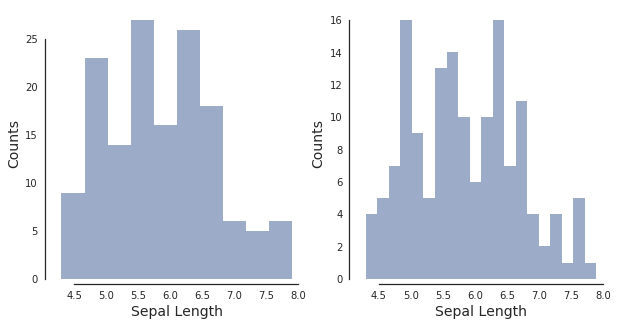

In [3]:
# Make comparative histograms, two different binning strategies
nbs = [10, 20]

# Make plots
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for ax, nb in zip(axs, nbs):
    ax.hist(iris['sepal_length'], bins=nb, alpha=0.5, color=sns.xkcd_rgb["denim blue"])
    ax.set_xlabel('Sepal Length', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    sns.despine(ax=ax, offset=5, trim=True)

plt.show()

-----

In the previous figure, increasing the number of bins makes the resulting histogram more sensitive to fluctuations in the data. In some cases, this variation might be important, but often, especially in relatively smaller data sets, this fluctuation simply captures the _noise_ in the sample. A second problem with the histogram is that, even when normalized, we do not have a simple, reliable means to sample from the distribution. 

As we mentioned previously, the histogram produces a binned density estimate, which when normalized can often be treated as a [probability mass (or density) distribution][wpd]. Sampling directly from a histogram is acceptable for discrete data (like flipping a coin or drawing cards from a deck), but for continuous functions, the lack of fidelity in a histogram caused by the bin width hinders the application of this technique. Also, if one wishes to use this distribution in a calculation, the histogram will inherently limit the precision of any calculation. 

As a result, we often require a functional approximation to the density. In the following figure, we demonstrate the problem with using the histogram itself to directly estimate this function by simply connecting the binned quantities (with the red line, which is a simple linear interpolation). While this line does capture the fluctuations in the data, it is not smoothly varying and is also clearly dependent on the binning strategy used to create the histogram.

-----

[wpd]: https://en.wikipedia.org/wiki/Probability_distribution

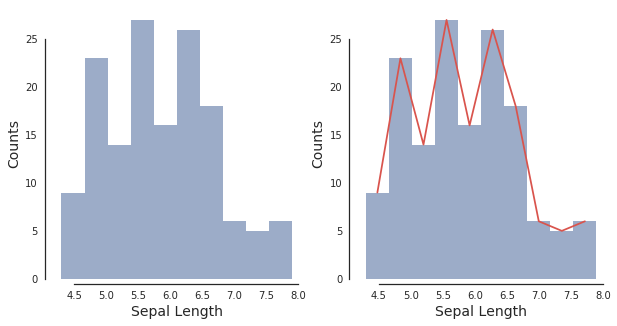

In [4]:
# Comparative histograms, same number of bins, connect bins centers in one.
nb = 10

# Make plot
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for idx, ax in enumerate(axs):
    
    # Make histogram, but grab output values to later connect bins
    n, bins, patches = ax.hist(iris['sepal_length'], bins=nb, \
                               alpha=0.5, color=sns.xkcd_rgb["denim blue"])
    ax.set_xlabel('Sepal Length', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    
    # Connect bin centers for second plot
    if idx:
        bc = bins[:-1] + (bins[1] - bins[0])/2.0
        ax.plot(bc, n, c=sns.xkcd_rgb["pale red"])

    sns.despine(ax=ax, offset=5, trim=True)

plt.show()

-----

## Kernel Density Estimation

As the preceding figure demonstrates, simply interpolating between the bin centers (even if a more sophisticated interpolation strategy is used) fails to capture the parent distribution of a set of features. As a result, more sophisticated techniques have been developed to functionally estimate the density of points. The most popular technique is known as [kernel density estimation][wkde] or KDE, which simply replaces each point by a function (or kernel) and accumulates the kernel contributions into a final functional form. The end result is generally normalized, creating a probability distribution for the data. Simply put, KDE works by replacing each discrete point by an approximating, continuous function.

The choice of kernel function clearly has an important impact on the functional representation, and ideally, has some physical motivation. The most popular kernel is the Gaussian, or normal, which is often appropriate given the nature of many sampling processes (where the errors on a measurement are normally distributed). Once a kernel function has been selected, the parameters of the kernel function will also need to be selected. Generally, the most important kernel function parameter is the bandwidth, which controls the _width_ the kernel function. This parameter acts similarly to the bin width of a histogram; too wide and the fluctuations in the data set are smoothed over, too fine and the (possible noise) fluctuations can overwhelm the signal.

If we simply want to create a KDE for visualization purposes, we can use Seaborn to [plot a KDE][skde] over a histogram, with an option to include the rug plot as well. This method is demonstrated in the following figure, where we generate a KDE for our Iris _Sepal Length_ features, over-plotting the KDE on the histogram. Notice how the KDE estimate more closely approximates the underlying histogram than our previous interpolation.

-----
[wkde]: https://en.wikipedia.org/wiki/Kernel_density_estimation
[skde]: http://stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html#kernel-density-estimaton

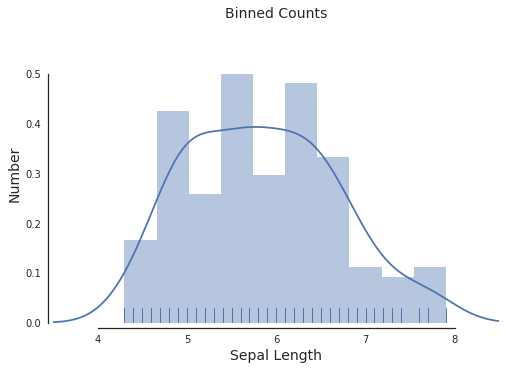

In [5]:
# Use Seaborn to make a KDE over histogram.
# Add in a rug plot for good measure.
ax = sns.distplot(iris['sepal_length'], kde=True, rug=True, bins=10)
ax.set_xlim(3.5, 8.5)
ax.set_ylim(0, 0.6)
ax.set_xlabel('Sepal Length', fontsize=14)
ax.set_ylabel('Number', fontsize=14)
ax.set_title('Binned Counts', fontsize=14)
sns.despine(offset=5, trim=True)

-----

While the KDE representation above clearly approximates the underlying data, it isn't clear how the KDE was itself constructed. Since the process is actually quite simple, in the following code cell we estimate the KDE by simply using Python (note that this example was drawn from a similar analysis performed in the Seaborn documentation). We first compute a bandwidth. In this case, we derive one based on the density of points; however, we could simply estimate the value. Next, we construct our support, or the space over which we will sample our kernel functions. Next, we create Gaussian kernels and sample them over our support. 

As shown in the following figure, the density of kernel functions follows the density of points. This shape is more easily seen since we changed the `alpha` parameter, which controls the transparency of the plot figures so that when multiple kernel functions overlap, the plot becomes bolder. As a result, we can visually see the mapping between the density of kernel functions and the density of points. The width of the kernel (or in this case Gaussian) functions is controlled by the bandwidth, and the kernel functions themselves are normalized to have unit area. 

-----

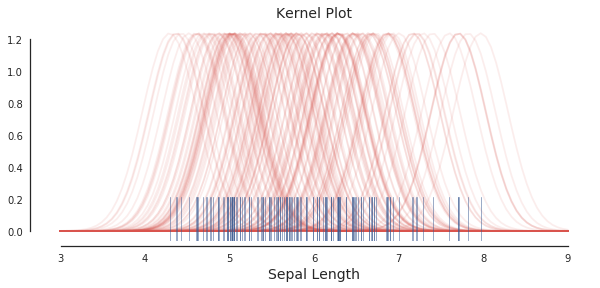

In [6]:
# KDE demonstration
# Modified from Seaborn documentation

from scipy import stats, integrate

# For kernel Density Estimation, 
# we need a Kernel model and a bandwidth.
# Here we assume a Gaussian Kernel, and the Seaborn bandwidth.

bw = 1.06 * data.std() * len(data) ** (-1 / 5.)
support = np.linspace(3, 9, 100)

# Make the plot
fig, ax = plt.subplots(figsize=(10, 4))

# We construct and plot a Gaussian over each 'rug fiber'
kernels = []
for dt in data:
    kernel = stats.norm(dt, bw).pdf(support)
    kernels.append(kernel)
    ax.plot(support, kernel, color=sns.xkcd_rgb["pale red"], alpha = 0.1)

# Now show rugplot as support.
sns.rugplot(a=data, ax=ax, color=sns.xkcd_rgb["denim blue"], height=0.2, linewidth=1, alpha = 0.5)
ax.set_xlabel('Sepal Length', fontsize=14)
ax.set_title('Kernel Plot', fontsize=14)

sns.despine(offset=5, trim=True)

-----

Given these kernel functions (in this case, we have 150 kernel functions, one for each Iris in the data set), we can combine them together to make the kernel density estimate. In the following code cell, we sum the kernels together and normalize by the total area to generate the KDE. We subsequently plot this new kernel density estimate over a rug plot of the jittered data to demonstrate that this KDE is equivalent to the Seaborn produced KDE.

An important distinction, however, is that we now have programmatically created this KDE and can use the function in the subsequent code to perform additional computations.

-----

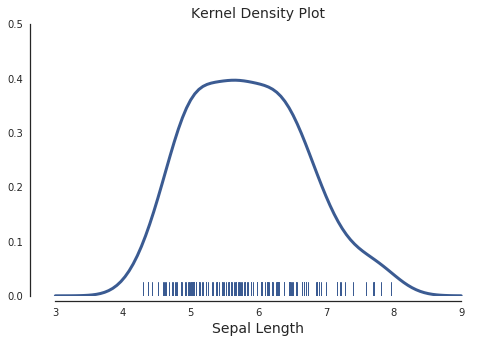

In [7]:
# Now combine the Gaussian kernels into a KDE

# To compute kernel density estimate, we sum up the 
# individual kernels and normalize by the total area.
density = np.sum(kernels, axis=0)
density /= integrate.trapz(density, support)

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the KDE
plt.plot(support, density, color=sns.xkcd_rgb["denim blue"], linewidth=3)
plt.ylim(0.0, 0.5)

# Now show rugplot as support.
sns.rugplot(data, color=sns.xkcd_rgb["denim blue"], linewidth=1)
ax.set_xlabel('Sepal Length', fontsize=14)
ax.set_title('Kernel Density Plot', fontsize=14)

sns.despine(offset=5, trim=True)
plt.show()

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we created a kernel density estimator for the Iris data. Now that you have run this notebook once, go back and make the following changes to see how the results change.

Change the dimension used in the one-dimensional KDE examples to one of the other Iris features, such as _Petal Width_ or _Petal Length_, and visualize the results. Does the change match your expecation?

-----

### Visualizing Distributions

In a previous module, we introduced the _boxplot_ as a technique for quickly displaying the distribution of a set of points. We can combine a kernel density estimate with the _boxplot_ to create a new visualization known as the _violinplot_. This new type of visualization modifies the sides of the box in the _boxplot_ to reflect the kernel density estimate of the data distribution, thereby providing more insight into the underlying data than is provided by a straight-edged _boxplot_. We demonstrate this below by first displaying a _boxplot_ for the _Sepal Length_ dimension, after which we display a _violinplot_ for the same data. Notice how the data distribution is indicated by the long sides of the filled glyph in the _violinplot_. By default, the data points are also displayed, although they can be hidden if so desired.

------

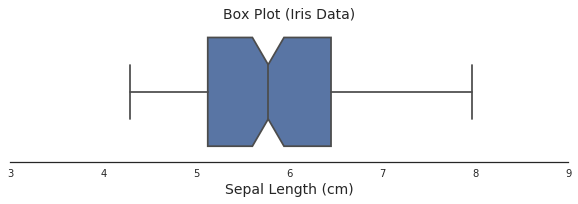

In [8]:
# Define plot layout
fig, axs = plt.subplots(figsize=(10, 2.5))

# sns.set_style("whitegrid")
ax = sns.boxplot(data, notch=True)

# Set x-axis length and label
ax.set_xlim(3, 9)
ax.set_xlabel('Sepal Length (cm)', fontsize=14)

# Title the plot
ax.set_title('Box Plot (Iris Data)', ha='center', fontsize=14)

sns.despine(left=True, offset=2, trim=True)

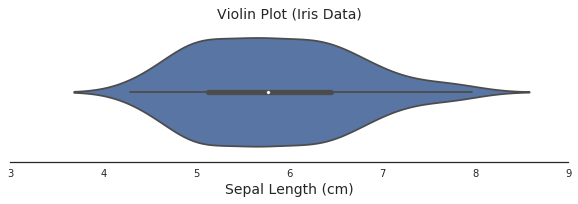

In [9]:
# Define plot layout
fig, axs = plt.subplots(figsize=(10, 2.5))

# sns.set_style("whitegrid")
ax = sns.violinplot(data, notch=True)

# Set x-axis length and label
ax.set_xlim(3, 9)
ax.set_xlabel('Sepal Length (cm)', fontsize=14)

# Title the plot
ax.set_title('Violin Plot (Iris Data)', ha='center', fontsize=14)

sns.despine(left=True, offset=2, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we created a kernel density estimator for the Iris data. Now that you have run this notebook once, go back and make the following changes to see how the results change.

Change the dimension used in the Seaborn violin plot example to one of the other Iris features, such as _Petal Width_ or _Petal Length_, and visualize the results. Does the result match your expectation?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. Wikipedia article on [Kernel Density Estimation][4]
1. [Seaborn Density Estimation][1]
2. [Scikit Learn 1-D Kernel Density Estimation][2]
3. A [detailed comparison][dec] between different kernel density estimation techniques by Jake VanderPlas

-----

[1]: http://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation
[2]: http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
[4]: https://en.wikipedia.org/wiki/Kernel_density_estimation
[dec]: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 